Cyna Shirazinejad, 02/11/2022
# Notebook 1: loading data for model generation

outline:

* load all data, including:
    * movies from AP2-tagRFP-T, DNM2-tagGFP2 cell lines
* filter out 'valid' tracks
    * valid' tracks are tracks which consist of tracks that appear and disappear 
      in the bounds of the movie with no more than 2 consecutive gaps
    * this is characterized when using AP2 as the primary channel for tracking
* creating dataframes of features from tracked events from fitted amplitude and position space to target feature space
    * each track will be decomposed into features, described in the notebook
    * the number of cell line tags will be included as a label (2 or 3)
    * the experiment number will be included as a label (1-8)
    * the date of the experiment
    * the cmeAnalysis classification as "DNM2-positive" (cmeAnalysisDNM2+) 
      or "DNM2-negative" will be included as a label (1 or 0)
* save dataframes and tracks for future notebooks

# user parameters to toggle plot-generation and/or dataframe construction and corresponding calculations

In [1]:
# set a path to the prefix of the pooled working directory with all of the data 
# the folder that contains all data for this analysis is 'ap2dynm2arcp3_project'
# (this folder, containing all raw and tracking data, is available on GitHub)
unique_user_path_tracks_beads = '/Volumes/Google Drive/My Drive/Drubin Lab/ap2dynm2arcp3_project/20220316_tirf_beads/split_tracking' # needs to be set for each user
unique_user_path_notebook = '/Users/cynashirazinejad/Documents/GitHub/Jin_Shirazinejad_et_al_branched_actin_manuscript/analysis/simplified_workflow_20220318_beads'
unique_user_saved_outputs = '/Volumes/GoogleDrive/My Drive/Drubin Lab/ap2dynm2arcp3_project/stable_outputs_beads'

# import all necessary Python modules

In [80]:
%load_ext autoreload
%autoreload 2
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns
import matplotlib as mpl

sys.path.append(unique_user_path_notebook+'/cmeAnalysisPostProcessingSimplified') # add custom Python scripts to the local path
import import_tracks
import feature_extraction_modular
import compare_tracks
import return_track_attributes

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# auto directory adding for notebooks

In [3]:
unique_user_saved_outputs

'/Volumes/GoogleDrive/My Drive/Drubin Lab/ap2dynm2arcp3_project/stable_outputs_beads'

In [4]:
if 'plots' not in os.listdir(unique_user_saved_outputs):
    os.mkdir(unique_user_saved_outputs+'/plots/')
if 'dataframes' not in os.listdir(unique_user_saved_outputs):
    os.mkdir(unique_user_saved_outputs+'/dataframes/')

In [5]:
# np.save(unique_user_path_notebook+'/unique_user_saved_outputs_simplified', unique_user_saved_outputs)

In [6]:
# unique_user_saved_outputs = str(np.load('unique_user_saved_outputs_simplified.npy'))

In [7]:
unique_user_saved_outputs

'/Volumes/GoogleDrive/My Drive/Drubin Lab/ap2dynm2arcp3_project/stable_outputs_beads'

In [8]:
analysis_metadata = {}
analysis_metadata['path_outputs'] = unique_user_saved_outputs
np.save('analysis_metadata', analysis_metadata)

In [9]:
analysis_metadata = np.load('analysis_metadata.npy', allow_pickle=True)

In [10]:
analysis_metadata.dtype

dtype('O')

In [11]:
# analysis_metadata.item()['path_tracks_ad_wildtype'] = unique_user_path_tracks_ad_wildtype
analysis_metadata.item()['path_notebook'] = unique_user_path_notebook
np.save('analysis_metadata', analysis_metadata)

In [12]:
analysis_metadata

array({'path_outputs': '/Volumes/GoogleDrive/My Drive/Drubin Lab/ap2dynm2arcp3_project/stable_outputs_beads', 'path_notebook': '/Users/cynashirazinejad/Documents/GitHub/Jin_Shirazinejad_et_al_branched_actin_manuscript/analysis/simplified_workflow_20220318_beads'},
      dtype=object)

# all track feature options:

conventions:
1. intensities: fitted amplitude of fluorescence (excluding fitted local background)
2. positions: fitted positions (x,y) of two dimensional point-spread-functions per frame in track
3. voxel-width = 108 nm

features:

1. 'lifetime': time between the first and last frame of detected AP2 (seconds)
2. 'max_int_ap2': maximum intensity (a.u. fluorescence)
3. 'max_int_dnm2': maximum intensity (a.u. fluorescence)
4. 'dist_traveled_ap2': track start-to-finish net movement (pixels)
5. 'dist_traveled_dnm2': track start-to-finish net movement (pixels)
6. 'max_dist_between_ap2_dnm2': the maximum frame-to-frame separation between AP2 and DNM2 (pixels)
7. 'md_ap2': mean displacement (pixels)
8. 'md_dnm2': mean displacement (pixels)
9. 'time_to_peak_ap2': time for the intensity to reach its peak (seconds) [0 if peak is first frame]
10. 'time_to_peak_dnm2': time for the intensity to reach its peak (seconds) [0 if peak is first frame]
11. 'time_after_peak_ap2': time for intensity to decay from its peak (seconds) [0 if peak is last frame]
12. 'time_after_peak_dnm2': time for intensity to decay from its peak (seconds) [0 if peak is last frame]
13. 'time_between_peaks_ap2_dnm2': time between peaks of two channels (seconds)
14. 'avg_int_change_to_peak_ap2': average change in intensity to the peak (a.u. fluorescence) [0 if peak is first frame]
15. 'avg_int_change_to_peak_dnm2': average change in intensity to the peak (a.u. fluorescence) [0 if peak is first frame]
16. 'avg_int_change_after_peak_ap2': average change in intensity after the peak (a.u. fluorescence) [0 if peak is last frame]
17. 'avg_int_change_after_peak_dnm2': average change in intensity after the peak (a.u. fluorescence) [0 if peak is last frame]
18. 'peak_int_diff_ap2_dnm2': difference between maximum intensity of channel 0 and channel 1 (a.u. fluorescence)
19. 'ratio_max_int_ap2_dnm2': ratio between maximum intensity of channel 0 and channel 1 (unitless)
20. 'mean_ap2': average of fluorescence (a.u. fluorescence)
21. 'mean_dnm2': average of fluorescence (a.u. fluorescence)
22. 'variation_ap2': variation of fluorescence (a.u. fluorescence^2)
23. 'variation_dnm2': variation of fluorescence (a.u. fluorescence^2)
24. 'skewness_ap2': skewness of fluorescence (unitless)
25. 'skewness_dnm2': skewness of fluorescence (unitless)
26. 'kurtosis_ap2': kurtosis of fluorescence (unitless)
27. 'kurtosis_dnm2': kurtosis of fluorescence (unitless)
28. 'number_significant_dnm2': number of significant detections with p-val lower than provided threshold (counts) [p-val < 0.01]
29. 'max_consecutive_significant_dnm2': maximum number of consecutive significant detections with p-val lower than provided threshold (counts) [p-val < 0.01]
30. 'fraction_significant_dnm2': fraction of event with significant detections with p-val lower than provided threshold (unitless) [p-val < 0.01]
31. 'fraction_peak_ap2': fraction of the event where the peak is located (unitless)
32. 'fraction_peak_dnm2': fraction of the event where the peak is located (unitless)

In [13]:
# the physical units of each track feature
feature_units = ['seconds',
                 'a.u. fluorescence',
                 'a.u. fluorescence',
                 'pixels',
                 'pixels',
                 'pixels',
                 'pixels',
                 'pixels',
                 'seconds',
                 'seconds',
                 'seconds',
                 'seconds',
                 'seconds',
                 'a.u. fluorescence',
                 'a.u. fluorescence',
                 'a.u. fluorescence',
                 'a.u. fluorescence',
                 'a.u. fluorescence',
                 'unitless',
                 'a.u. fluorescence',
                 'a.u. fluorescence',
                 'a.u. fluorescence**2',
                 'a.u. fluorescence**2',
                 'unitless',
                 'unitless',
                 'unitless',
                 'unitless',
                 'counts',
                 'counts',
                 'unitless',
                 'unitless',
                 'unitless']

In [14]:
possible_track_features_labels = ['lifetime',
                                 'max_int_ap2',
                                 'max_int_dnm2',
                                 'dist_traveled_ap2',
                                 'dist_traveled_dnm2',
                                 'max_dist_between_ap2_dnm2',
                                 'md_ap2',
                                 'md_dnm2',
                                 'time_to_peak_ap2',
                                 'time_to_peak_dnm2',
                                 'time_after_peak_ap2',
                                 'time_after_peak_dnm2',
                                 'time_between_peaks_ap2_dnm2',
                                 'avg_int_change_to_peak_ap2',
                                 'avg_int_change_to_peak_dnm2',
                                 'avg_int_change_after_peak_ap2',
                                 'avg_int_change_after_peak_dnm2',
                                 'peak_int_diff_ap2_dnm2',
                                 'ratio_max_int_ap2_dnm2',
                                 'mean_ap2',
                                 'mean_dnm2',
                                 'variation_ap2',
                                 'variation_dnm2',
                                 'skewness_ap2',
                                 'skewness_dnm2',
                                 'kurtosis_ap2',
                                 'kurtosis_dnm2',
                                 'number_significant_dnm2',
                                 'max_consecutive_significant_dnm2',
                                 'fraction_significant_dnm2',
                                 'fraction_peak_ap2',
                                 'fraction_peak_dnm2']

In [15]:
possible_track_features = ['lifetime',
                            'max_int_ch0',
                            'max_int_ch1',
                            'dist_traveled_ch0',
                            'dist_traveled_ch1',
                            'max_dist_between_ch0-ch1',
                            'md_ch0',
                            'md_ch1',
                            'time_to_peak_ch0',
                            'time_to_peak_ch1',
                            'time_after_peak_ch0',
                            'time_after_peak_ch1',
                            'time_between_peaks_ch0-ch1',
                            'avg_int_change_to_peak_ch0',
                            'avg_int_change_to_peak_ch1',
                            'avg_int_change_after_peak_ch0',
                            'avg_int_change_after_peak_ch1',
                            'peak_int_diff_ch0-ch1',
                            'ratio_max_int_ch0-ch1',
                            'mean_ch0',
                            'mean_ch1',
                            'variation_ch0',
                            'variation_ch1',
                            'skewness_ch0',
                            'skewness_ch1',
                            'kurtosis_ch0',
                            'kurtosis_ch1',
                            'number_significant_ch1',
                            'max_consecutive_significant_ch1',
                            'fraction_significant_ch1',
                            'fraction_peak_ch0',
                            'fraction_peak_ch1']

In [16]:
analysis_metadata.item()['feature_units'] = feature_units
analysis_metadata.item()['possible_track_features'] = possible_track_features
analysis_metadata.item()['possible_track_features_labels'] = possible_track_features_labels

# compare categories

In [25]:
cfatc = compare_tracks.compare_frequencies_all_track_categories

In [30]:
df_bead_categories = cfatc([unique_user_path_tracks_beads],
                                  [['Cell']])

tests

folders to mine for track set 1:
71_200722_ap2-dnm2-arpc3_ap2-dnm2_arpc3_beads_wildtype_Cell12_1s
72_200722_ap2-dnm2-arpc3_ap2-dnm2_arpc3_beads_wildtype_Cell13_1s


loading tracks in set..
tracks in set 1 of 2
tracks in set 2 of 2






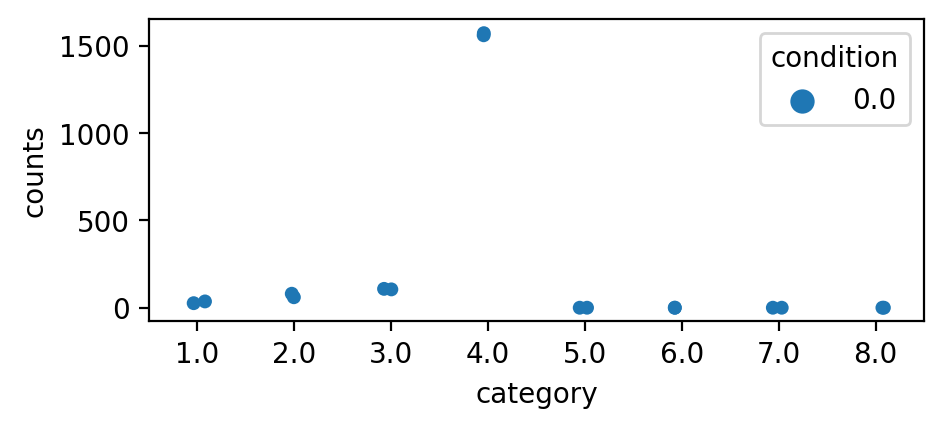

In [33]:
plt.figure(dpi=200, figsize=(5,2))
sns.stripplot(data=df_bead_categories,
                  x='category',
                  y='counts',
                  hue='condition',
                  dodge=True)


# extract features from all tracks, labeled by experiment (0-7), number of imaging channels/labels, and date of experiment

In [18]:
experiment_groups = {}

beads_group = {}
beads_group['path'] = unique_user_path_tracks_beads
beads_group['df'] = 'df_beads'
beads_group['tracks'] = 'merged_beads'

experiment_groups['beads_group'] = beads_group

In [19]:
analysis_metadata.item()['experiment_groups'] = experiment_groups

In [20]:
np.save('analysis_metadata', analysis_metadata)

In [34]:
import_tracks.upload_tracks_and_metadata(analysis_metadata,
                                         'beads_group',
                                         [4],
                                         ['Cell'],
                                         possible_track_features,
                                         possible_track_features_labels)


folders to mine:
71_200722_ap2-dnm2-arpc3_ap2-dnm2_arpc3_beads_wildtype_Cell12_1s
72_200722_ap2-dnm2-arpc3_ap2-dnm2_arpc3_beads_wildtype_Cell13_1s


uploading and saving tracks...


finished uploading tracks

extracting features...

completed feature extraction

creating dataframe...

saving dataframe...

saving tracks...

done


In [41]:
analysis_metadata = np.load('analysis_metadata.npy', allow_pickle=True)

In [42]:
analysis_metadata

array({'path_outputs': '/Volumes/GoogleDrive/My Drive/Drubin Lab/ap2dynm2arcp3_project/stable_outputs_20220211', 'path_notebook': '/Users/cynashirazinejad/Documents/GitHub/Jin_Shirazinejad_et_al_branched_actin_manuscript/analysis/simplified_workflow_20220211', 'feature_units': ['seconds', 'a.u. fluorescence', 'a.u. fluorescence', 'pixels', 'pixels', 'pixels', 'pixels', 'pixels', 'seconds', 'seconds', 'seconds', 'seconds', 'seconds', 'a.u. fluorescence', 'a.u. fluorescence', 'a.u. fluorescence', 'a.u. fluorescence', 'a.u. fluorescence', 'unitless', 'a.u. fluorescence', 'a.u. fluorescence', 'a.u. fluorescence**2', 'a.u. fluorescence**2', 'unitless', 'unitless', 'unitless', 'unitless', 'counts', 'counts', 'unitless', 'unitless', 'unitless'], 'possible_track_features': ['lifetime', 'max_int_ch0', 'max_int_ch1', 'dist_traveled_ch0', 'dist_traveled_ch1', 'max_dist_between_ch0-ch1', 'md_ch0', 'md_ch1', 'time_to_peak_ch0', 'time_to_peak_ch1', 'time_after_peak_ch0', 'time_after_peak_ch1', 'time

In [43]:
df_merged_features = output[0]

In [44]:
df_merged_features

,lifetime,max_int_ap2,max_int_dnm2,dist_traveled_ap2,dist_traveled_dnm2,max_dist_between_ap2_dnm2,md_ap2,md_dnm2,time_to_peak_ap2,time_to_peak_dnm2,...,fraction_peak_dnm2,cmeAnalysis_dynamin2_prediction,experiment_number,number_of_tags,cell_line_tags,current_tracked_channels,experiment_type,cell_condition,framerate,date
0,216.0,1796.284550322625,740.5167555488542,7.203811618034117,7.203811618034117,2.6306555388877793,0.5662615075017282,0.7259134903726635,159.0,186.0,...,0.8230088495575221,1.0,0.0,2.0,ap2-dnm2,ap2-dnm2,wildtype,no-treatment,1s,200804
1,201.0,2215.53269478876,1505.4332733213157,17.220725894550196,14.507134678864624,3.79752603297003,0.42457356996667195,0.9126711550232961,111.0,107.0,...,0.5071090047393365,1.0,0.0,2.0,ap2-dnm2,ap2-dnm2,wildtype,no-treatment,1s,200804
2,201.0,864.9760871693655,421.40569093332397,17.621865760603715,17.130473203716313,3.472331504351925,0.5665883248115021,0.7764040384690212,42.0,44.0,...,0.20853080568720378,1.0,0.0,2.0,ap2-dnm2,ap2-dnm2,wildtype,no-treatment,1s,200804
3,192.0,509.7951655896294,356.30252072661403,10.804210974044102,13.29284212911614,5.888568784172939,0.4287357708278232,1.0581767956988943,44.0,190.0,...,0.9405940594059405,1.0,0.0,2.0,ap2-dnm2,ap2-dnm2,wildtype,no-treatment,1s,200804
4,188.0,1636.4223863360899,883.606435993711,11.255090440377664,7.793073957870642,5.53100638637804,0.41579163122869783,0.753372444487746,174.0,169.0,...,0.8535353535353535,1.0,0.0,2.0,ap2-dnm2,ap2-dnm2,wildtype,no-treatment,1s,200804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59234,2.0,28.623953094644072,19.04267536740483,1.8796908488080917,2.915253367017944,2.389665408897578,1.0923364294023667,1.3549845245985959,6.0,0.0,...,0.0,0.0,7.0,2.0,ap2-dnm2,ap2-dnm2,wildtype,no-treatment,1s,200819
59235,2.0,15.16406513256624,14.946216236886015,7.447355313813243,2.6664318562049107,6.454258735272825,2.453557868995878,1.923303689919584,6.0,3.0,...,0.25,0.0,7.0,2.0,ap2-dnm2,ap2-dnm2,wildtype,no-treatment,1s,200819
59236,2.0,21.87979204779379,26.215771722354116,4.384565199592009,1.665403908980792,4.318207296451148,1.8737702023929197,2.4187978088233795,6.0,6.0,...,0.5,0.0,7.0,2.0,ap2-dnm2,ap2-dnm2,wildtype,no-treatment,1s,200819
59237,2.0,20.236622704590612,13.95459467883471,1.0793876124245154,2.8886438427430146,3.897008864376748,0.843483102219812,2.105213983074413,6.0,11.0,...,0.9166666666666666,0.0,7.0,2.0,ap2-dnm2,ap2-dnm2,wildtype,no-treatment,1s,200819


In [39]:
beads_0 = np.load('/Volumes/Google Drive/My Drive/Drubin Lab/ap2dynm2arcp3_project/stable_outputs_beads/dataframes/merged_beads_0.npy', allow_pickle=True)
beads_1 = np.load('/Volumes/Google Drive/My Drive/Drubin Lab/ap2dynm2arcp3_project/stable_outputs_beads/dataframes/merged_beads_1.npy', allow_pickle=True)

In [43]:
len(beads_0), len(beads_1)

(1560, 1572)

In [46]:
beads_merged = list(beads_0) + list(beads_1)

In [47]:
len(beads_merged)

3132

In [85]:
avg_ch0_1_sep = []
avg_ch0_2_sep = []

absolute_x_pos_ch0 = []
absolute_y_pos_ch0 = []

absolute_x_pos_ch1 = []
absolute_y_pos_ch1 = []

absolute_x_pos_ch2 = []
absolute_y_pos_ch2 = []

for i in range(len(beads_merged)):
    
    x_positions_ch0 = return_track_attributes.return_puncta_x_position_whole_track(beads_merged, i, 0)
    y_positions_ch0 = return_track_attributes.return_puncta_y_position_whole_track(beads_merged, i, 0)

    x_positions_ch1 = return_track_attributes.return_puncta_x_position_whole_track(beads_merged, i, 1)
    y_positions_ch1 = return_track_attributes.return_puncta_y_position_whole_track(beads_merged, i, 1)
    
    x_positions_ch2 = return_track_attributes.return_puncta_x_position_whole_track(beads_merged, i, 2)
    y_positions_ch2 = return_track_attributes.return_puncta_y_position_whole_track(beads_merged, i, 2)

    absolute_x_pos_ch0.append(x_positions_ch0)
    absolute_y_pos_ch0.append(y_positions_ch0)

    absolute_x_pos_ch1.append(x_positions_ch1)
    absolute_y_pos_ch1.append(y_positions_ch1)

    absolute_x_pos_ch2.append(x_positions_ch2)
    absolute_y_pos_ch2.append(y_positions_ch2)
    
    distance_between_ch0nnels_0_1=[]
    distance_between_ch0nnels_0_2=[]

    for j in range(len(x_positions_ch0)):

        distance_between_ch0nnels_0_1.append(np.sqrt((x_positions_ch0[j]-x_positions_ch1[j])**2 + (y_positions_ch0[j]-y_positions_ch1[j])**2))
        distance_between_ch0nnels_0_2.append(np.sqrt((x_positions_ch0[j]-x_positions_ch2[j])**2 + (y_positions_ch0[j]-y_positions_ch2[j])**2))
        
    avg_ch0_1_sep.append(0.108*np.mean(distance_between_ch0nnels_0_1))
    avg_ch0_2_sep.append(0.108*np.mean(distance_between_ch0nnels_0_2))

(array([1233., 1695.,  131.,   26.,    8.,    5.,   11.,    9.,    8.,
           6.]),
 array([0.        , 0.03304148, 0.06608296, 0.09912444, 0.13216593,
        0.16520741, 0.19824889, 0.23129037, 0.26433185, 0.29737333,
        0.33041482]),
 <a list of 10 Patch objects>)

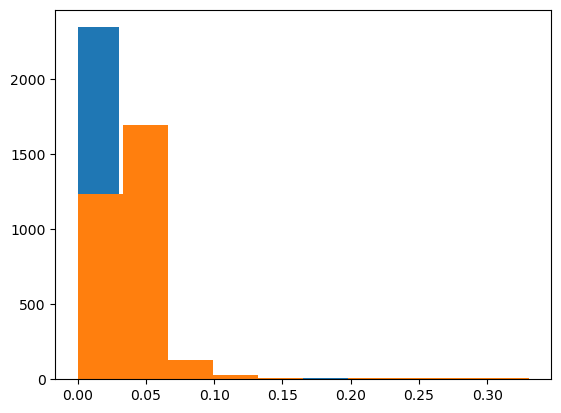

In [86]:
plt.hist(avg_ch0_1_sep)
plt.hist(avg_ch0_2_sep)

In [87]:
image_size = 512
center_offset = 50
spacing = 5
min_x = np.arange(image_size/2-center_offset, 0, -spacing)
min_y = np.arange(image_size/2-center_offset, 0, -spacing)
max_x = np.arange(image_size/2+center_offset, image_size, spacing)
max_y = np.arange(image_size/2+center_offset, image_size, spacing)

In [88]:
events_in_boundary = []
boundary_condition = []
separation_ch0_1 = []
separation_ch0_2 = []

for i in range(len(min_x)):
    
    events_temp = []
    
    current_boundaries = (min_x[i], 
                          min_y[i],
                          max_x[i],
                          max_y[i])
    
    for j in range(len(absolute_x_pos_ch0)):
        
        in_bounds = True
        
        x_pos_temp = absolute_x_pos_ch0[j]
        
        for x_pos in x_pos_temp:
            
            if x_pos<current_boundaries[0] or x_pos>current_boundaries[2]:
                
                in_bounds = False
            
        y_pos_temp = absolute_y_pos_ch0[j]
        
        for y_pos in y_pos_temp:
            
            if y_pos<current_boundaries[1] or y_pos>current_boundaries[3]:
                
                in_bounds = False
        
        if in_bounds:
            
            boundary_condition.append(i)
            separation_ch0_1.append(avg_ch0_1_sep[j])
            separation_ch0_2.append(avg_ch0_2_sep[j])

            events_temp.append(avg_ch0_1_sep[j])
            
    events_in_boundary.append(events_temp)

In [89]:
avg_sep = []
std_sep = []
num_events = []
for i in range(len(events_in_boundary)):
    num_events.append(len(events_in_boundary[i]))
    avg_sep.append(np.mean(events_in_boundary[i]))
    std_sep.append(np.std(events_in_boundary[i]))

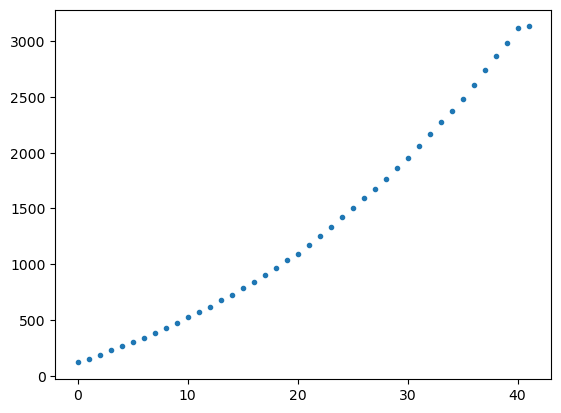

In [90]:
plt.plot(num_events, '.')

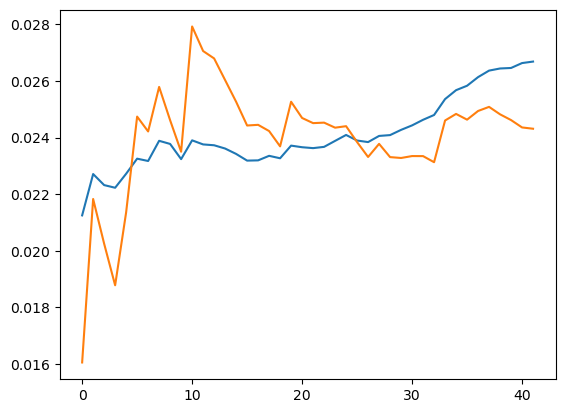

In [91]:
plt.plot(avg_sep)
plt.plot(std_sep)

In [92]:
df_array = np.array((boundary_condition, separation_ch0_1, separation_ch0_2)).T

In [93]:
df_boundaries = pd.DataFrame(df_array, columns=['boundary', 'separation01', 'separation02'])

In [94]:
df_boundaries

,boundary,separation01,separation02
0,0.0,0.021627,0.016410
1,0.0,0.012474,0.007753
2,0.0,0.018144,0.017956
3,0.0,0.021528,0.016775
4,0.0,0.032209,0.011827
...,...,...,...
55953,41.0,0.032799,0.020565
55954,41.0,0.018206,0.063087
55955,41.0,0.034314,0.257736
55956,41.0,0.037274,0.062705


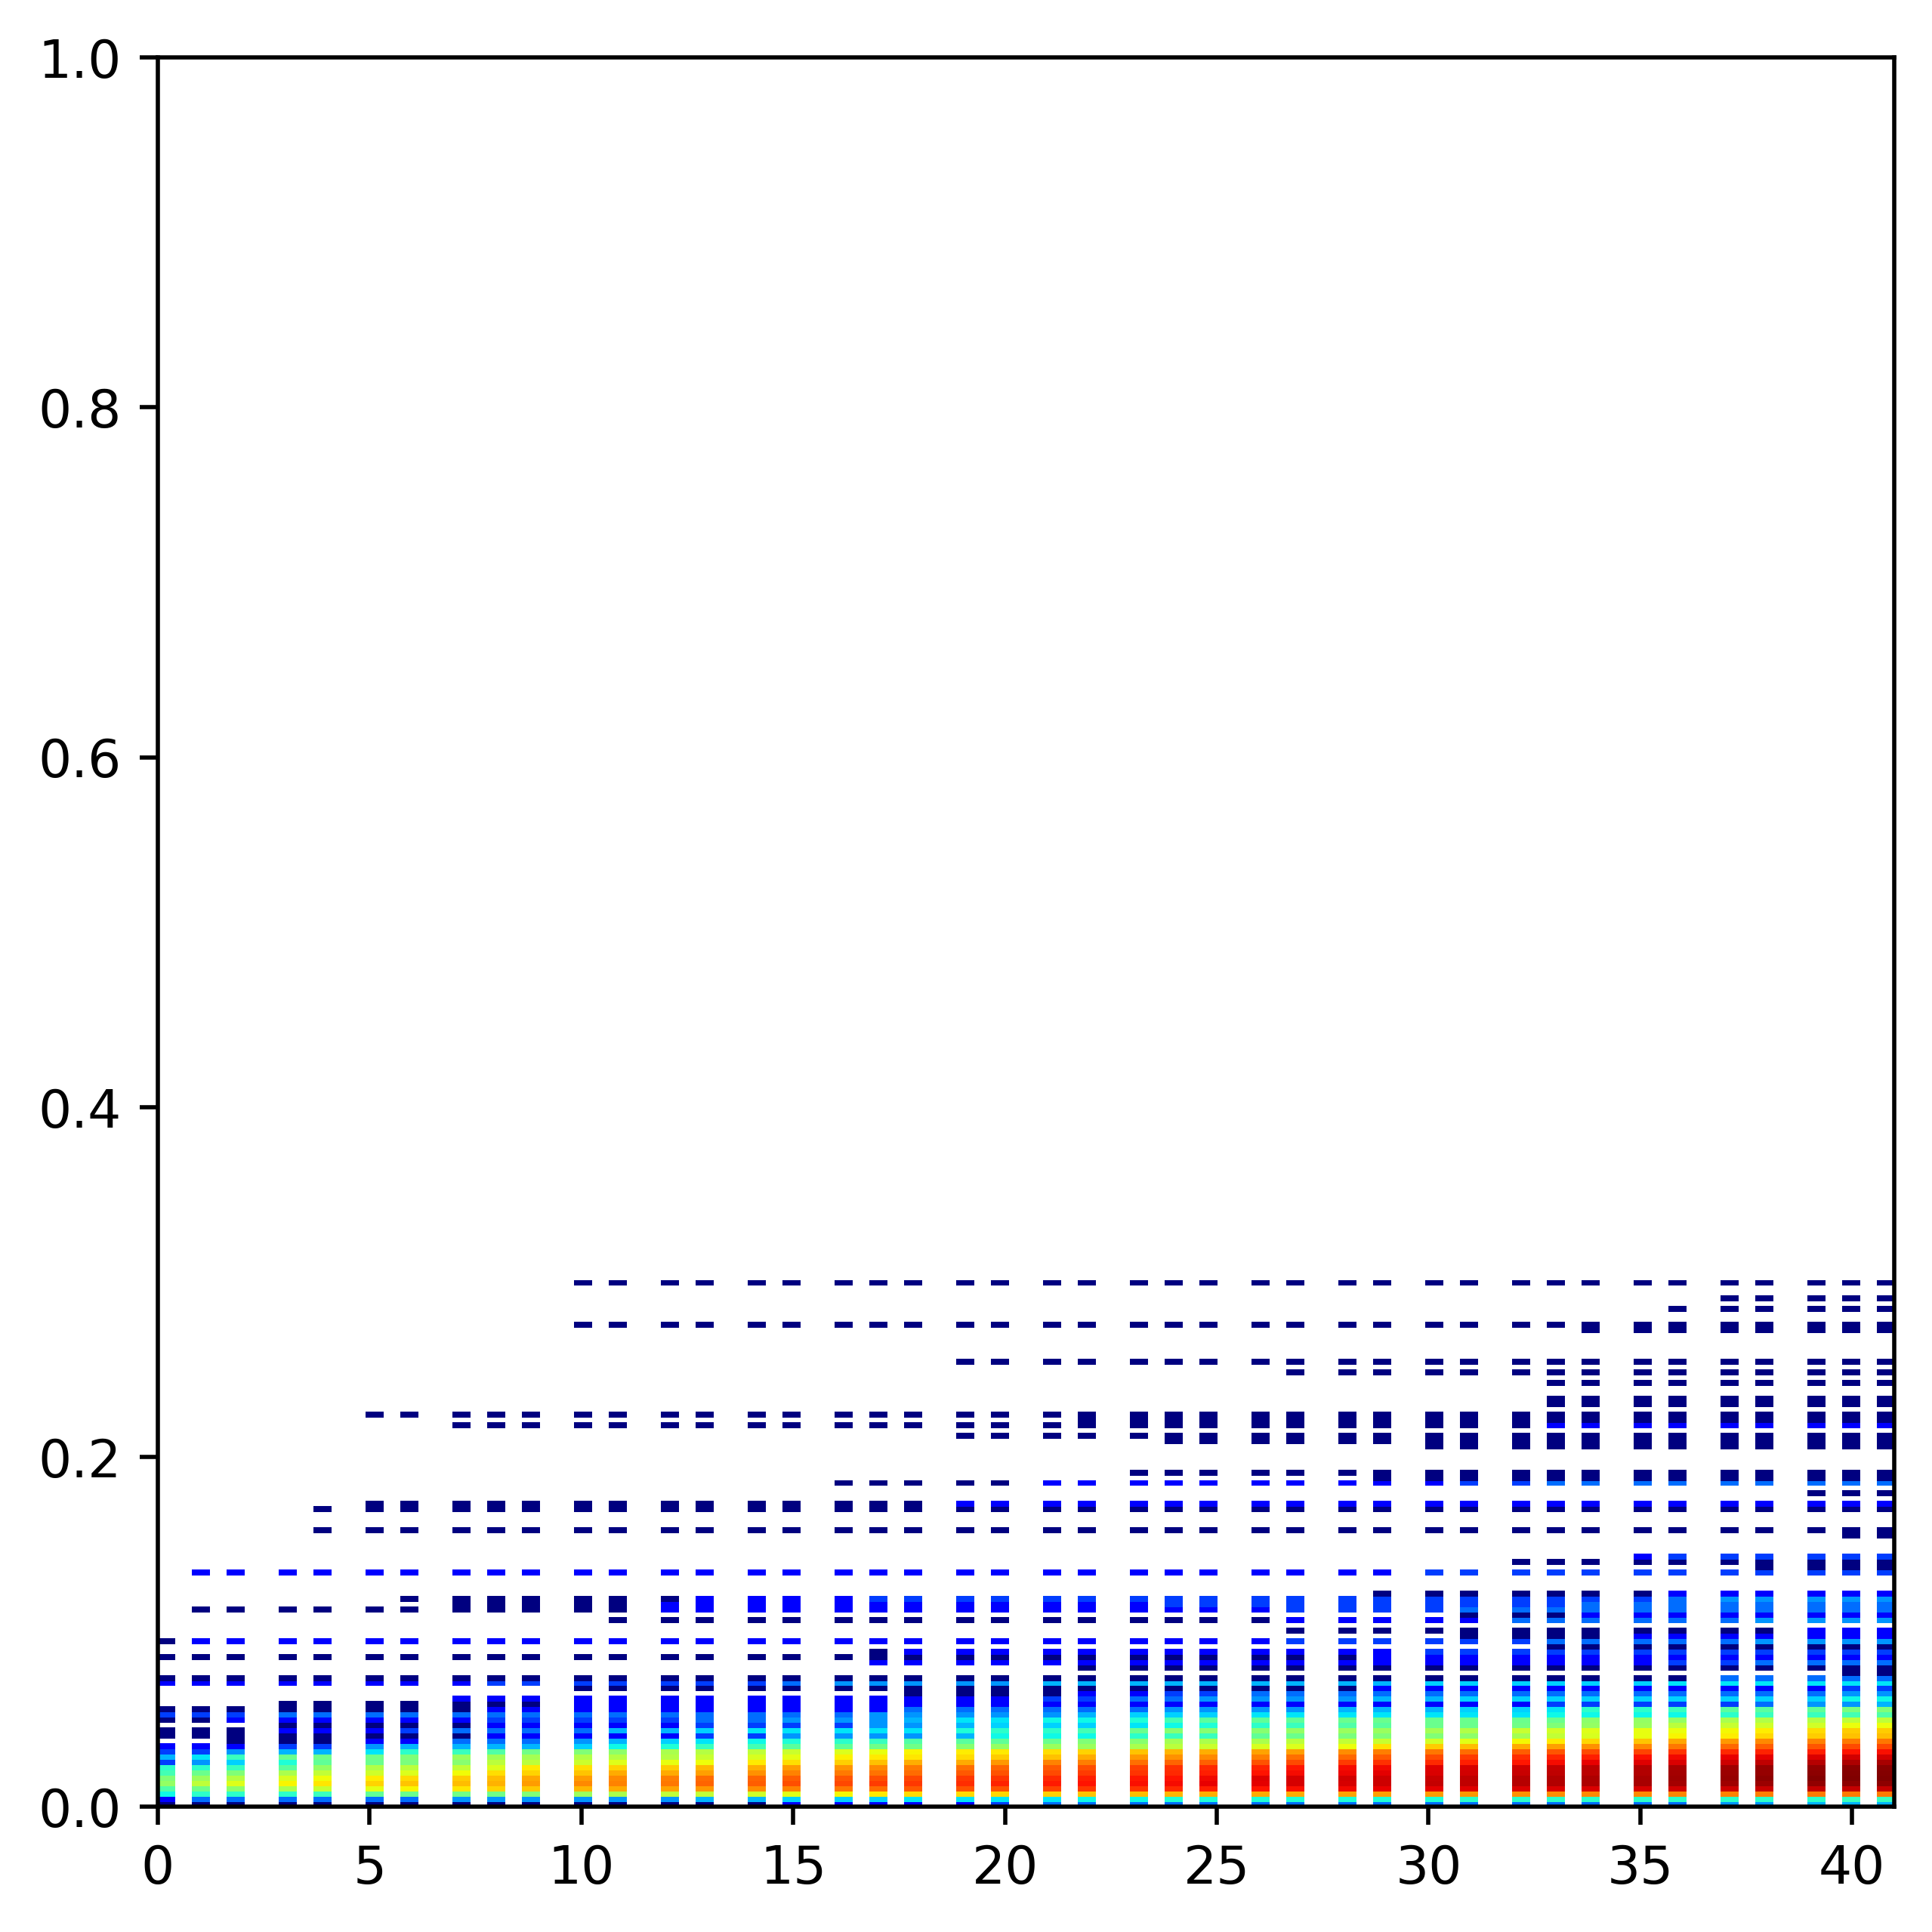

In [97]:
plt.style.use('default')
fig, ax = plt.subplots(1,1, constrained_layout=True, figsize=(5,5), dpi=500)
sc = ax.hist2d(df_boundaries['boundary'],
                df_boundaries['separation01'], 
                bins=100,
                 norm=mpl.colors.LogNorm(),
                 alpha=1,
                 density=True,
                 cmap='jet')
plt.ylim([0,1])
plt.savefig('/Users/cynashirazinejad/Desktop/beads01-again.png')

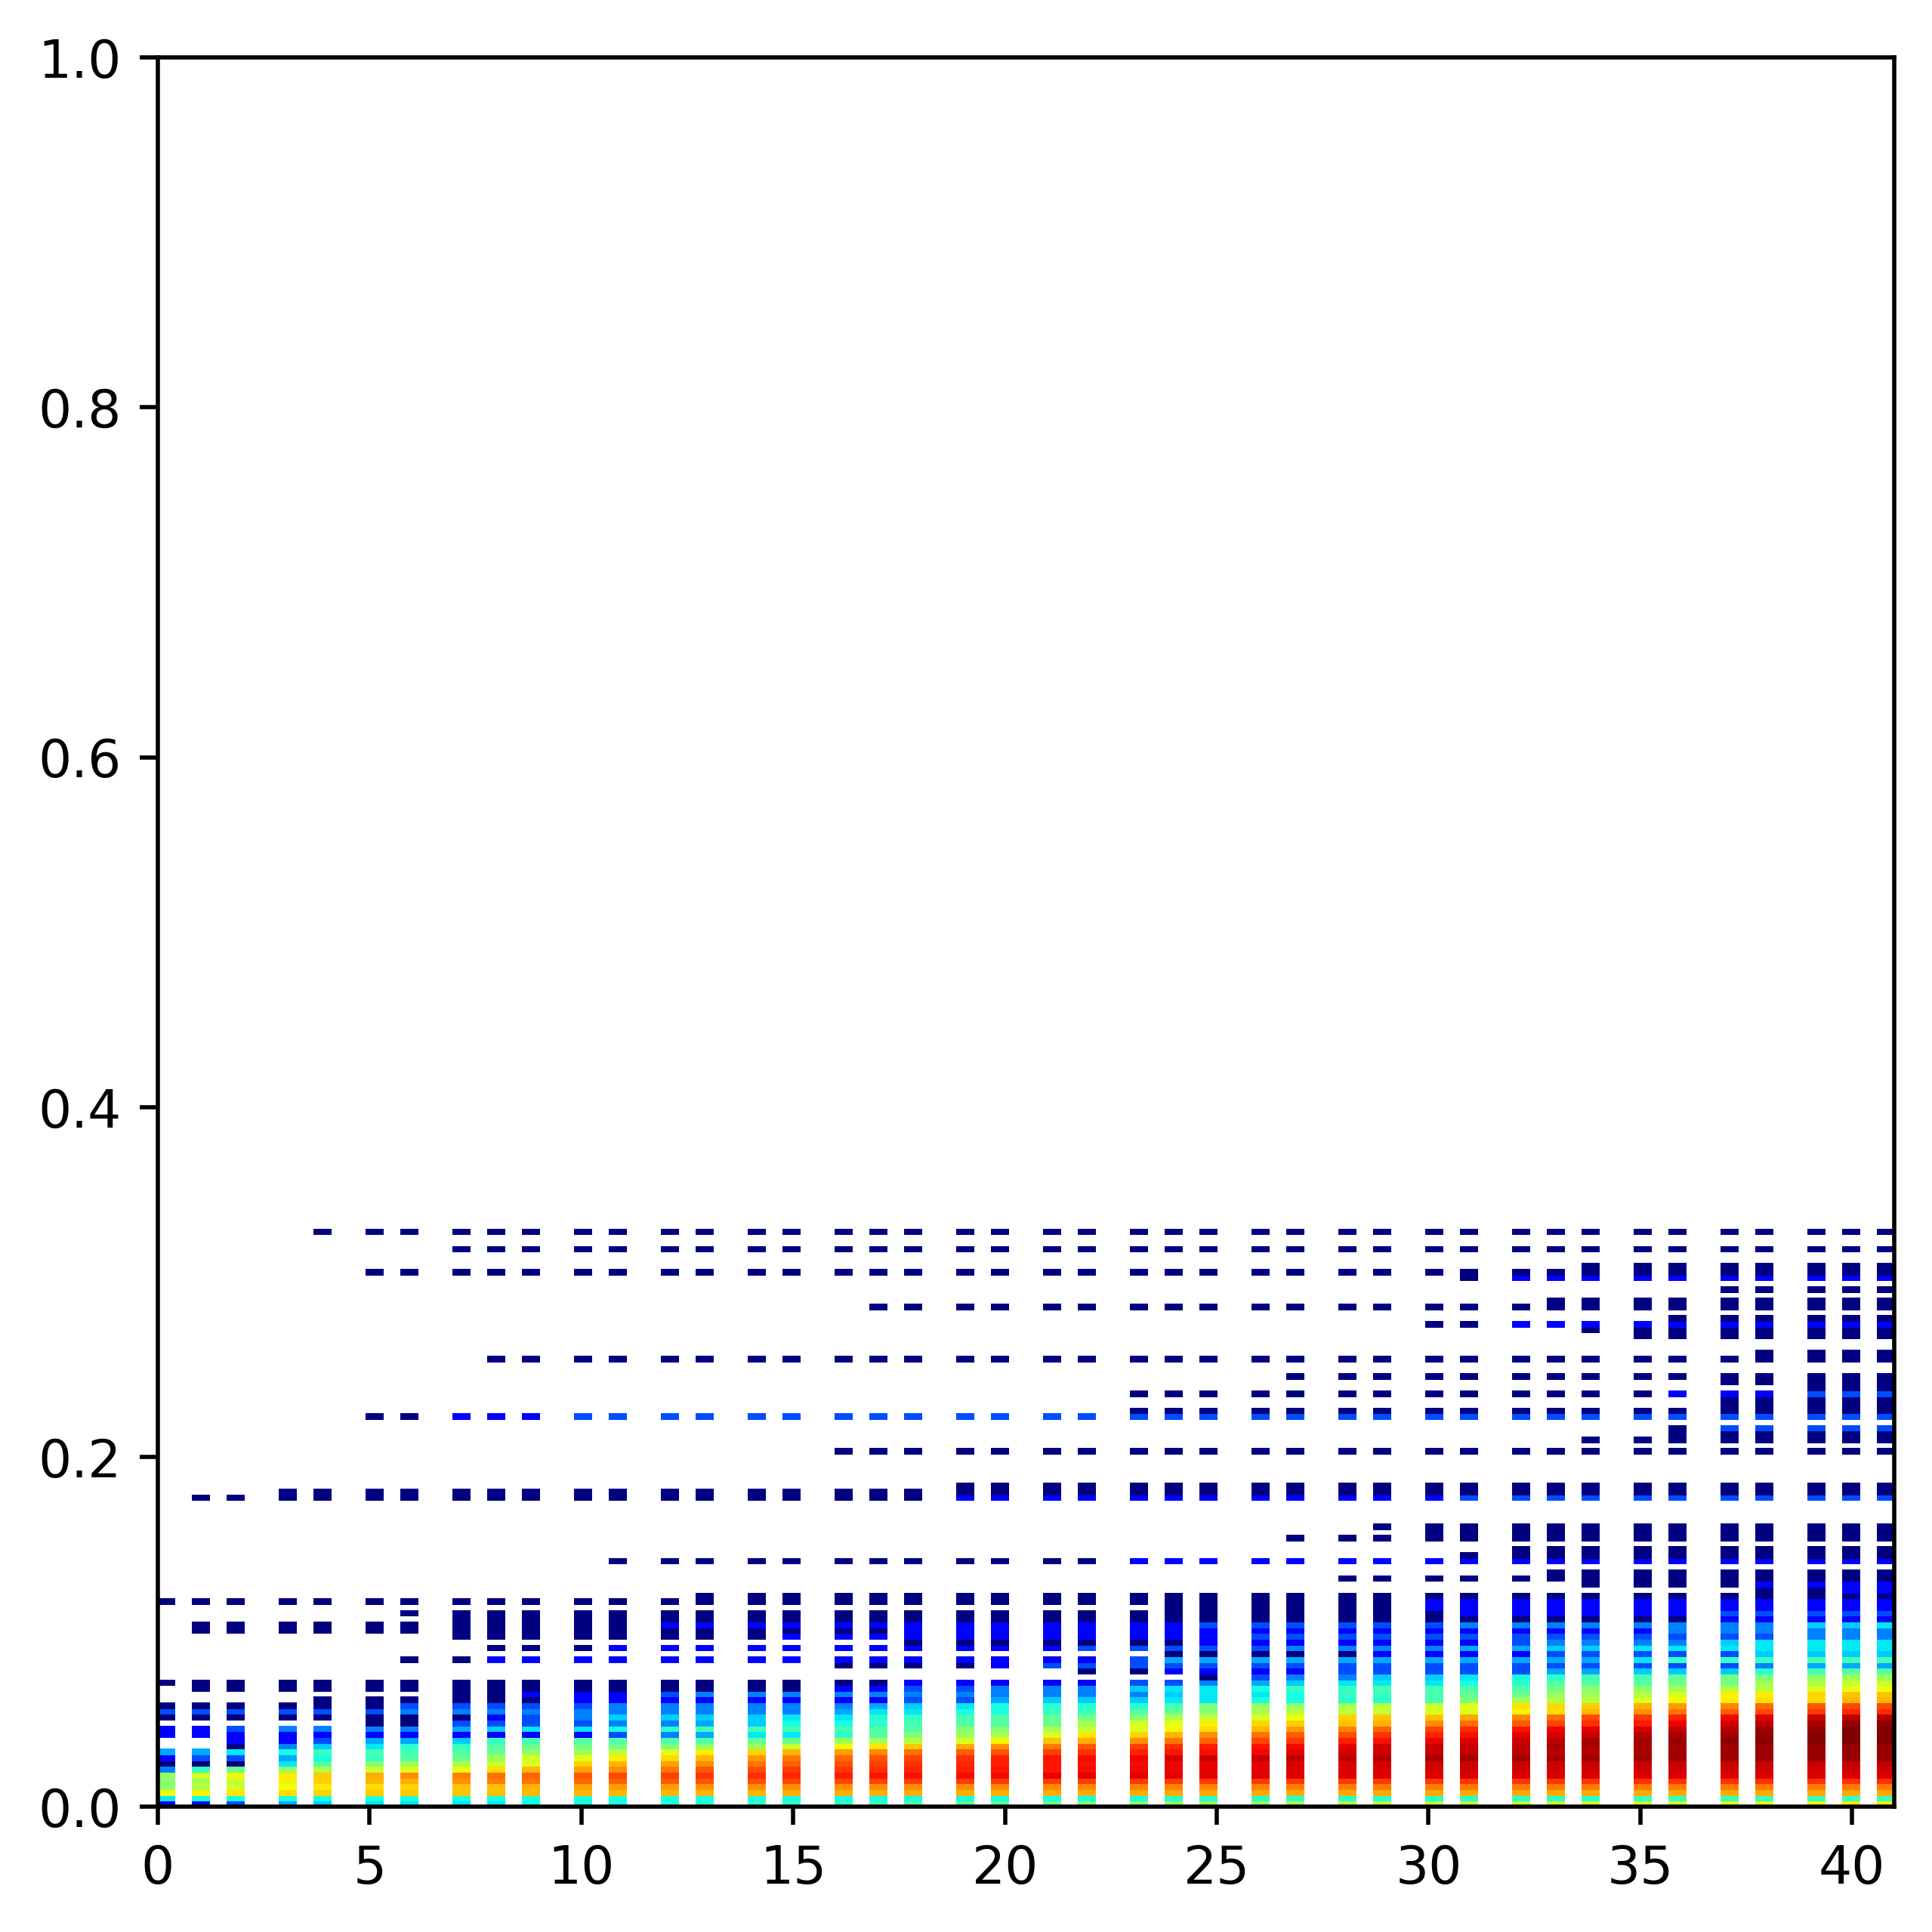

In [96]:
plt.style.use('default')
fig, ax = plt.subplots(1,1, constrained_layout=True, figsize=(5,5), dpi=500)
sc = ax.hist2d(df_boundaries['boundary'],
                df_boundaries['separation02'], 
                bins=100,
                 norm=mpl.colors.LogNorm(),
                 alpha=1,
                 density=True,
                 cmap='jet')
plt.ylim([0,1])
plt.savefig('/Users/cynashirazinejad/Desktop/beads02.png')